Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$\sum_c f_c(\mu) \cdot \nu_c(\mu) \cdot \frac{p_c\left(x\right)}{p_\text{c}(x)} = \mu \cdot \nu_{H \to \tau\tau}(\mu) \cdot  \frac{p_{H \to \tau\tau}\left(x\right)}{p_\text{c}(x)} + \nu_{t\bar{t}}(\mu) \cdot  \frac{p_{t\bar{t}}\left(x\right)}{p_\text{c}(x)} + \nu_{Z \to \tau\tau}(\mu) \cdot  \frac{p_{Z \to \tau\tau}\left(x\right)}{p_\text{c}(x)}$$

where,
$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_\text{c}(x|\alpha_m^\pm)} $$

**HistFactory-style Model**

One of the landmark proposals of the ATLAS NSBI papers [link](https://inspirehep.net/literature/2854620) was the use of HistFactory-style models in NSBI analys. This assumes that **the effect of various independent sources of uncertainty in the likelihood model can be factorized**:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_\text{c}(x|\alpha_m^\pm)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_\text{c}(x|\alpha_m^\pm)}$$

This is now another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_\text{c}(x|\alpha_m^\pm)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_\text{c}(x|\alpha_m^\pm), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)} \, , \frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_\text{c}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_\text{c}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

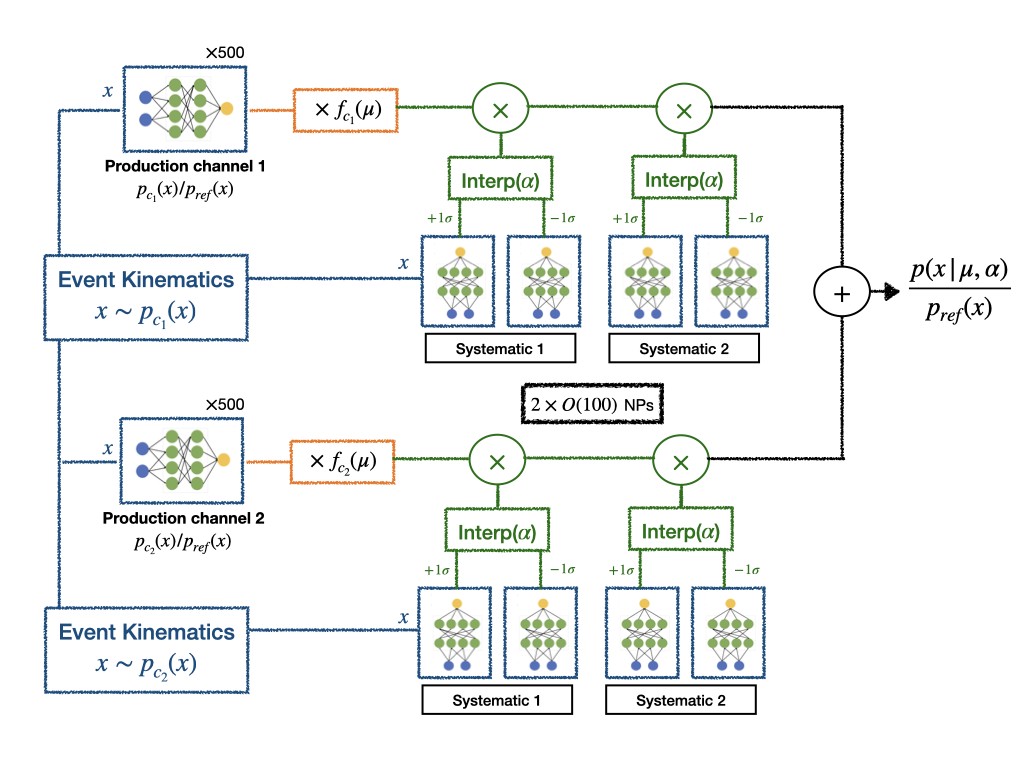

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import density_ratio_trainer

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-11-11 11:46:26.273531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-11 11:46:26.399963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-11 11:46:26.434263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-11 11:46:27.272430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

In [2]:
importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

# Load the config file to get metadata like training features 
config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')


In [3]:
# Input features for training - these features are the same ones used for nominal training
features, features_scaling = config.get_training_features()

In [4]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

branches_to_load = features + ['presel_score']

# Initialize the nsbi_common_utils.datasets helper class
Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load =  branches_to_load)

# Load the full dataset, including systematic variations defined in the config file
dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)


In [5]:
# Filter out events to get the NSBI signal region (defined as "SR" in the config file)
dataset_SR_dict = Datasets.filter_region_by_type(dataset_incl_dict, region = "SR")

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)} \, , \frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [6]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import density_ratio_trainer

PATH_TO_SAVED_DATA = './saved_datasets/'

NN_training_syst_process  = {}
path_to_ratios            = {}
path_to_figures           = {}
path_to_models            = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

# If you want a fresh training, delete all existing models so they wont be loaded
# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False


for process in config.get_basis_samples():
    
    NN_training_syst_process[process]   = {}
    path_to_ratios[process]             = {}
    path_to_figures[process]            = {}
    path_to_models[process]             = {}
    
    
    for dict_syst in config.config["Systematics"]:
        
        syst = dict_syst["Name"]

        NN_training_syst_process[process][syst] = {}
        path_to_ratios[process][syst]           = {}
        path_to_figures[process][syst]          = {}
        path_to_models[process][syst]           = {}

        for direction in ["Up", "Dn"]:
            
            samples_to_train = config.get_samples_in_syst_for_training(syst, direction)
            
            if (process not in samples_to_train):
                print(f"Nothing to train for {process} in {syst+direction} uncertainty")
                del NN_training_syst_process[process][syst], path_to_ratios[process][syst], path_to_figures[process][syst], path_to_models[process][syst]
                continue

            syst_key_name = syst + '_' + direction
            
            dataset_syst_nom = Datasets.prepare_basis_training_dataset(dataset_SR_dict[syst_key_name], [process], dataset_SR_dict["Nominal"], [process])

            # Save paths
            top_path                                    = f'{PATH_TO_SAVED_DATA}output_training_systematics/'
            output_name                                 = f'{process}_{syst}_{direction}'
            output_dir                                  = f'{top_path}general_output_{output_name}'
            path_to_ratios[process][syst][direction]    = f'{top_path}output_ratios_{output_name}/'
            path_to_figures[process][syst][direction]   = f'{top_path}output_figures_{output_name}/'
            path_to_models[process][syst][direction]    = f'{top_path}output_model_params_{output_name}/'
            
            NN_training_syst_process[process][syst][direction] = density_ratio_trainer(dataset_syst_nom, 
                                                                                   dataset_syst_nom['weights_normed'].to_numpy(),
                                                                                   dataset_syst_nom['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures[process][syst][direction],
                                                                                    path_to_ratios=path_to_ratios[process][syst][direction], 
                                                                                    path_to_models=path_to_models[process][syst][direction],
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)
                


2025-11-11 11:47:15 | INFO | Training Logs | Sum of weights of class 0: 0.7000000316506947
2025-11-11 11:47:15 | INFO | Training Logs | Sum of weights of class 1: 0.7000013678157049
2025-11-11 11:47:15 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 11:47:17.547659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 11:47:20 | INFO | Training Logs | Using Callbacks


Epoch 1/100


2025-11-11 11:47:24.056278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-11 11:47:24.757060: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - binary_accuracy: 0.5030 - loss: 5.4789e-07 - val_binary_accuracy: 0.5052 - val_loss: 5.4785e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5043 - loss: 5.4788e-07 - val_binary_accuracy: 0.5053 - val_loss: 5.4784e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5042 - loss: 5.4787e-07 - val_binary_accuracy: 0.5094 - val_loss: 5.4785e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5051 - loss: 5.4786e-07 - val_binary_accuracy: 0.5081 - val_loss: 5.4784e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5047 - loss: 5.4786e-07 - val_binary_accuracy: 0.5073 - val_loss: 5.4782e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5060 - loss: 5.4785e-07 - val_binary_accuracy: 0.5074 - 

2025-11-11 11:54:07 | INFO | Training Logs | Finished Training
2025-11-11 11:54:07.528340: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 11:54:07.535328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 11:54:07.749948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 11:54:07.778477: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 11:54:07.783830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

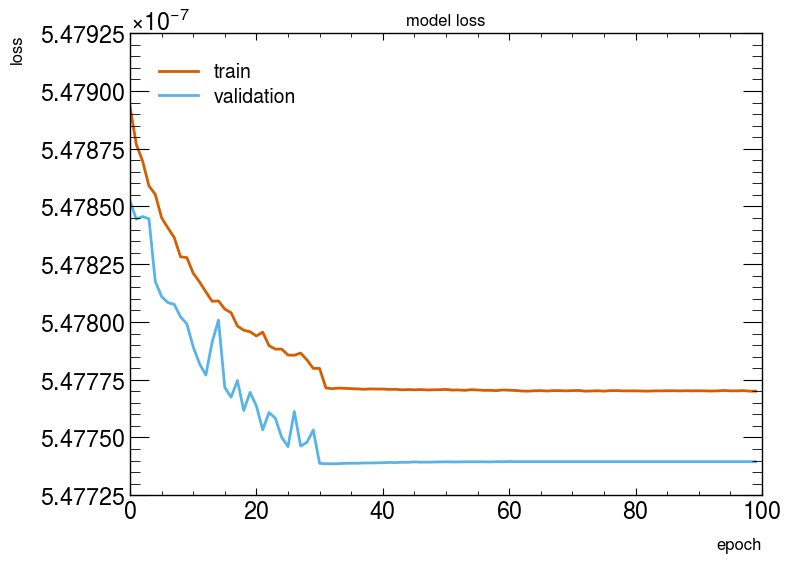

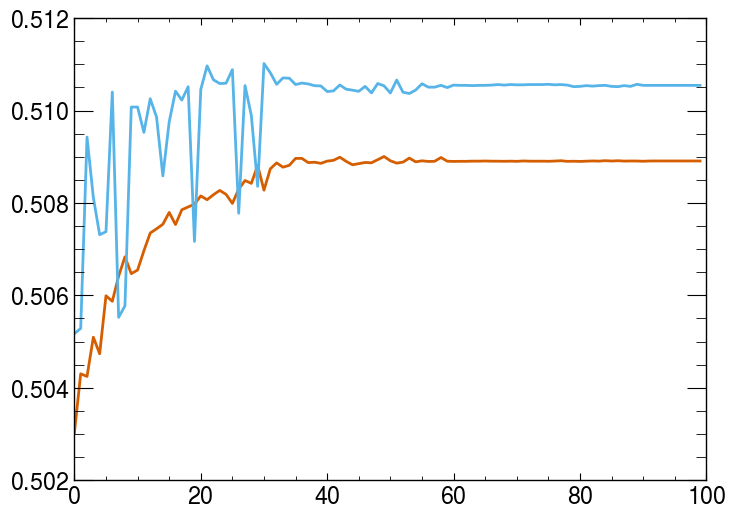

2025-11-11 11:54:17 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000148728759974


2025-11-11 11:54:17 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000148728759974



2025-11-11 11:54:17 | INFO | Training Logs | starting ensemble training
2025-11-11 11:54:18 | INFO | Training Logs | Sum of weights of class 0: 0.6999987780064645
2025-11-11 11:54:18 | INFO | Training Logs | Sum of weights of class 1: 0.6999991726106694
2025-11-11 11:54:18 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 11:54:18 | INFO | Training Logs | Using Call

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - binary_accuracy: 0.5037 - loss: 5.4909e-07 - val_binary_accuracy: 0.5007 - val_loss: 5.4913e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5049 - loss: 5.4907e-07 - val_binary_accuracy: 0.5061 - val_loss: 5.4910e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5050 - loss: 5.4906e-07 - val_binary_accuracy: 0.5038 - val_loss: 5.4907e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5054 - loss: 5.4905e-07 - val_binary_accuracy: 0.5069 - val_loss: 5.4908e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5064 - loss: 5.4904e-07 - val_binary_accuracy: 0.5022 - val_loss: 5.4907e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5061 - loss: 5.4904e-07 - val_binary_accuracy

2025-11-11 12:01:03 | INFO | Training Logs | Finished Training
2025-11-11 12:01:03.447451: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:01:03.453098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:01:03.688359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:01:03.712687: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:01:03.718290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

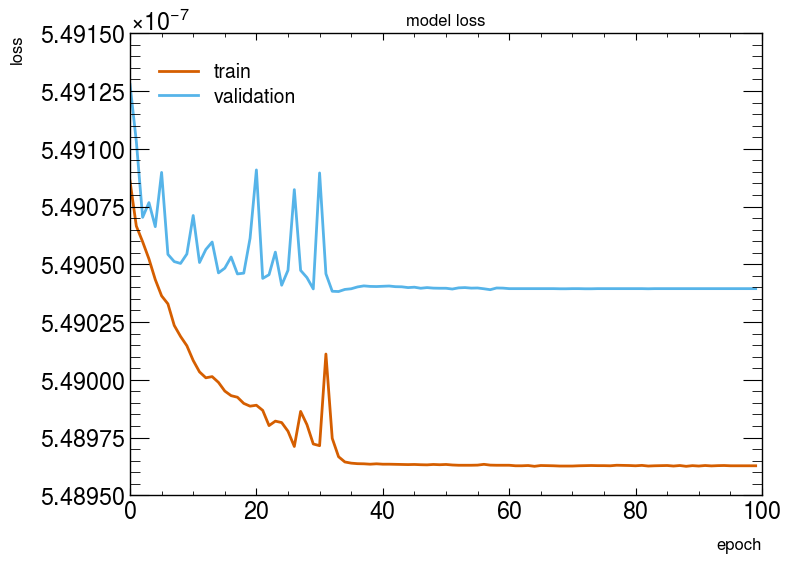

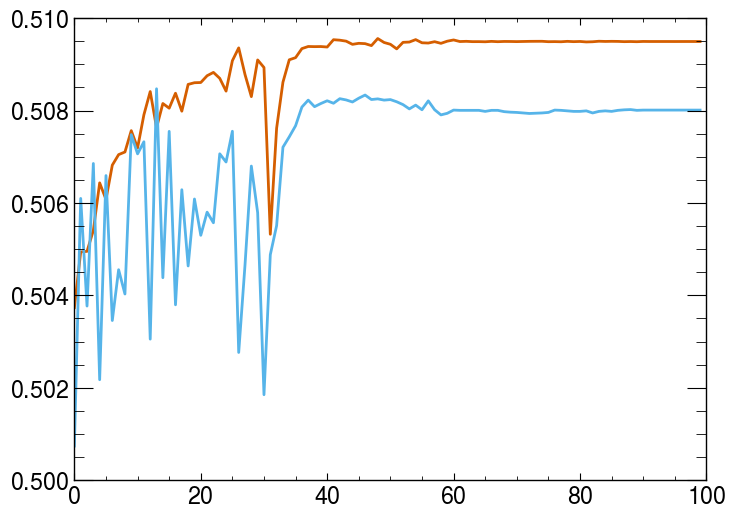

2025-11-11 12:01:11 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000379407046287


2025-11-11 12:01:11 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000379407046287



2025-11-11 12:01:11 | INFO | Training Logs | starting ensemble training
2025-11-11 12:01:12 | INFO | Training Logs | Sum of weights of class 0: 0.7000005095552465
2025-11-11 12:01:13 | INFO | Training Logs | Sum of weights of class 1: 0.7000013988158466
2025-11-11 12:01:13 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:01:13 | INFO | Training Logs | Using Call

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - binary_accuracy: 0.5055 - loss: 5.4647e-07 - val_binary_accuracy: 0.5091 - val_loss: 5.4642e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5081 - loss: 5.4641e-07 - val_binary_accuracy: 0.5067 - val_loss: 5.4640e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5097 - loss: 5.4637e-07 - val_binary_accuracy: 0.5117 - val_loss: 5.4632e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5105 - loss: 5.4633e-07 - val_binary_accuracy: 0.5125 - val_loss: 5.4628e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5111 - loss: 5.4630e-07 - val_binary_accuracy: 0.5120 - val_loss: 5.4625e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5113 - loss: 5.4627e-07 - val_binary_accuracy

2025-11-11 12:07:59 | INFO | Training Logs | Finished Training
2025-11-11 12:07:59.402350: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:07:59.407652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:07:59.653099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:07:59.676976: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:07:59.682329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

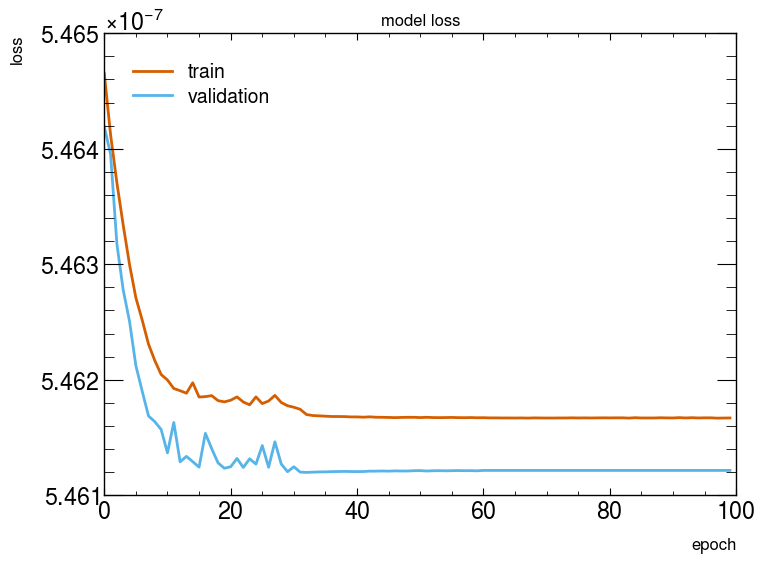

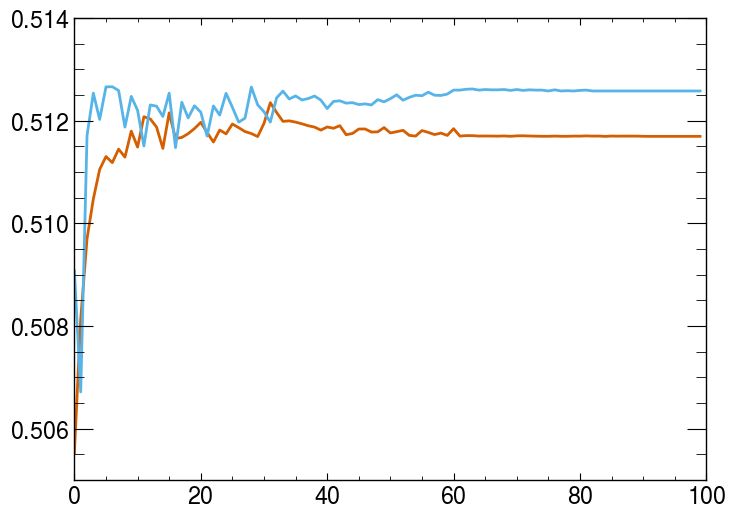

2025-11-11 12:08:07 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000338564057352


2025-11-11 12:08:07 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000338564057352



2025-11-11 12:08:07 | INFO | Training Logs | starting ensemble training
2025-11-11 12:08:08 | INFO | Training Logs | Sum of weights of class 0: 0.6999993233074551
2025-11-11 12:08:08 | INFO | Training Logs | Sum of weights of class 1: 0.6999998781114871
2025-11-11 12:08:08 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:08:09 | INFO | Training Logs | Using Call

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - binary_accuracy: 0.5069 - loss: 5.5035e-07 - val_binary_accuracy: 0.5061 - val_loss: 5.5031e-07 - learning_rate: 0.1000
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5082 - loss: 5.5030e-07 - val_binary_accuracy: 0.5088 - val_loss: 5.5026e-07 - learning_rate: 0.1000
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5100 - loss: 5.5026e-07 - val_binary_accuracy: 0.5104 - val_loss: 5.5022e-07 - learning_rate: 0.1000
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5106 - loss: 5.5022e-07 - val_binary_accuracy: 0.5119 - val_loss: 5.5018e-07 - learning_rate: 0.1000
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5114 - loss: 5.5018e-07 - val_binary_accuracy: 0.5119 - val_loss: 5.5015e-07 - learning_rate: 0.1000
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5118 - loss: 5.5015e-07 - val_binary_accuracy

2025-11-11 12:14:51 | INFO | Training Logs | Finished Training
2025-11-11 12:14:51.609555: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:14:51.614926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:14:51.837813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:14:51.862399: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:14:51.867728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

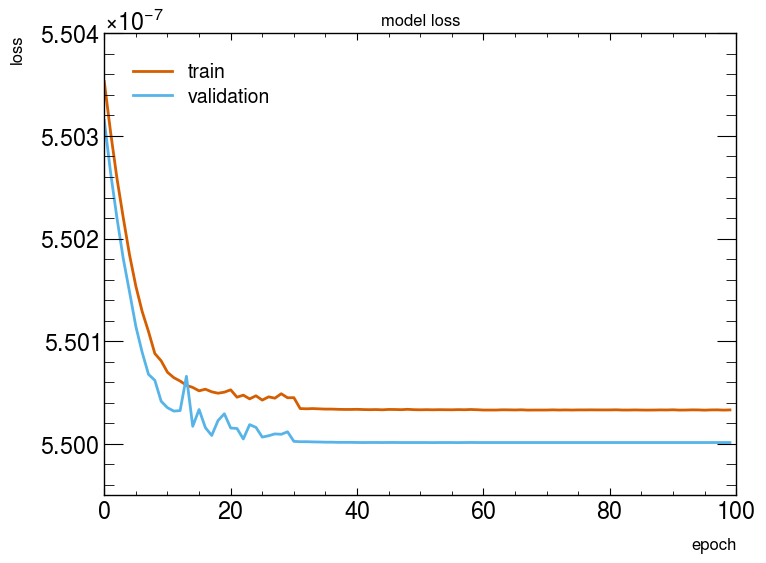

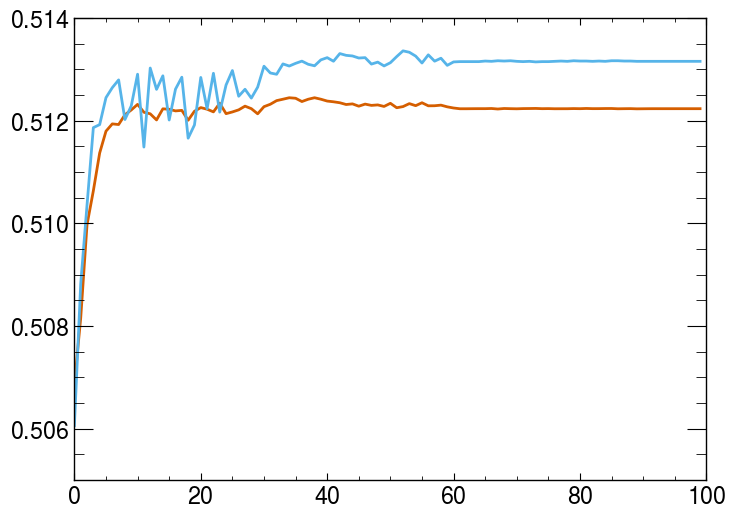

2025-11-11 12:14:59 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.000056777325746


2025-11-11 12:14:59 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.000056777325746



2025-11-11 12:14:59 | INFO | Training Logs | starting ensemble training
2025-11-11 12:14:59 | INFO | Training Logs | Sum of weights of class 0: 0.7000066041946411
2025-11-11 12:14:59 | INFO | Training Logs | Sum of weights of class 1: 0.6999960541725159
2025-11-11 12:14:59 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:14:59 | INFO | Training Logs | Using Callba

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - binary_accuracy: 0.5014 - loss: 4.0224e-06 - val_binary_accuracy: 0.5062 - val_loss: 4.0218e-06 - learning_rate: 0.1000
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.5048 - loss: 4.0217e-06 - val_binary_accuracy: 0.5026 - val_loss: 4.0229e-06 - learning_rate: 0.1000
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5061 - loss: 4.0217e-06 - val_binary_accuracy: 0.5060 - val_loss: 4.0220e-06 - learning_rate: 0.1000
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5072 - loss: 4.0215e-06 - val_binary_accuracy: 0.5031 - val_loss: 4.0232e-06 - learning_rate: 0.1000
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5059 - loss: 4.0217e-06 - val_binary_accuracy: 0.5029 - val_loss: 4.0219e-06 - learning_rate: 0.1000
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5066 - loss: 4.0216e-06 - val_binary_accuracy: 0.5040 - 

2025-11-11 12:16:11 | INFO | Training Logs | Finished Training
2025-11-11 12:16:11.240342: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:16:11.245805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:16:11.427785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:16:11.451019: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:16:11.456344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

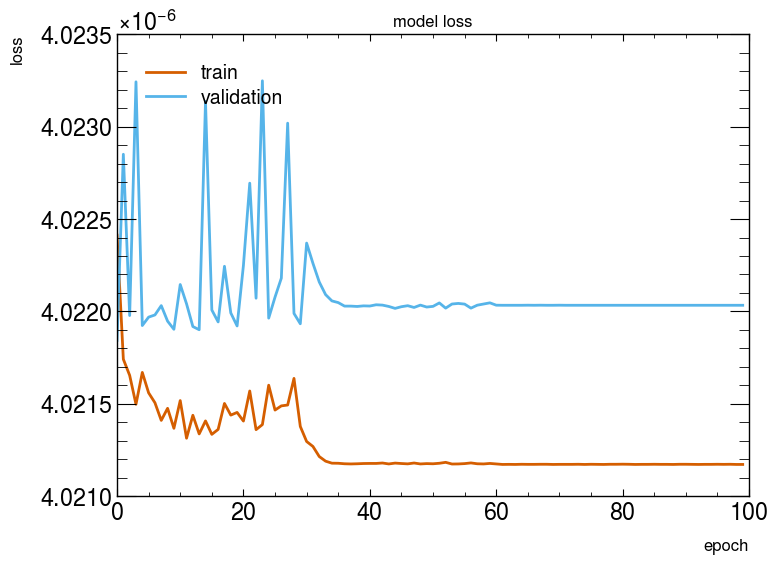

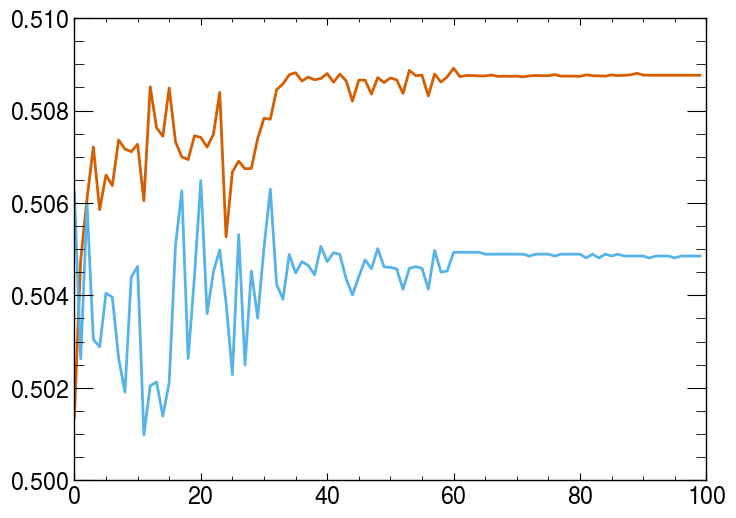

2025-11-11 12:16:14 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000018827875157


2025-11-11 12:16:14 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000018827875157



2025-11-11 12:16:14 | INFO | Training Logs | starting ensemble training
2025-11-11 12:16:14 | INFO | Training Logs | Sum of weights of class 0: 0.6999949812889099
2025-11-11 12:16:14 | INFO | Training Logs | Sum of weights of class 1: 0.7000085711479187
2025-11-11 12:16:14 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:16:14 | INFO | Training Logs | Using Call

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - binary_accuracy: 0.5035 - loss: 3.9987e-06 - val_binary_accuracy: 0.5051 - val_loss: 3.9975e-06 - learning_rate: 0.1000
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.5071 - loss: 3.9980e-06 - val_binary_accuracy: 0.5045 - val_loss: 3.9978e-06 - learning_rate: 0.1000
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5084 - loss: 3.9979e-06 - val_binary_accuracy: 0.4997 - val_loss: 3.9989e-06 - learning_rate: 0.1000
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5080 - loss: 3.9977e-06 - val_binary_accuracy: 0.5068 - val_loss: 3.9975e-06 - learning_rate: 0.1000
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5083 - loss: 3.9978e-06 - val_binary_accuracy: 0.5050 - val_loss: 3.9980e-06 - learning_rate: 0.1000
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5083 - loss: 3.9976e-06 - val_binary_accuracy: 0.4988 - 

2025-11-11 12:17:25 | INFO | Training Logs | Finished Training
2025-11-11 12:17:25.924670: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:17:25.929950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:17:26.114205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:17:26.138063: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:17:26.143493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

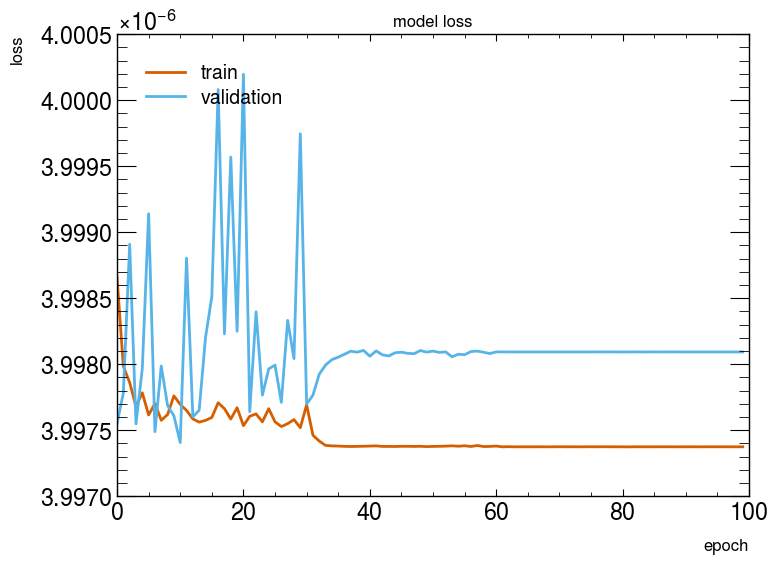

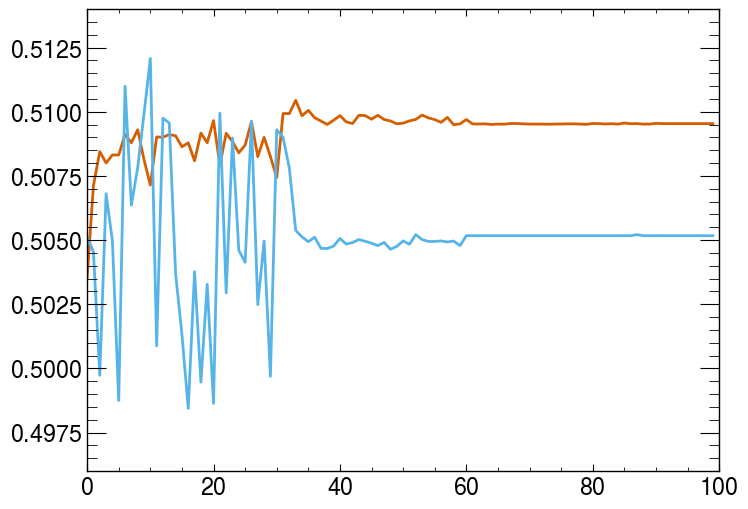

2025-11-11 12:17:28 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0001349455861603


2025-11-11 12:17:28 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0001349455861603



2025-11-11 12:17:28 | INFO | Training Logs | starting ensemble training
2025-11-11 12:17:29 | INFO | Training Logs | Sum of weights of class 0: 0.6999996900558472
2025-11-11 12:17:29 | INFO | Training Logs | Sum of weights of class 1: 0.6999999284744263
2025-11-11 12:17:29 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:17:29 | INFO | Training Logs | Using Call

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - binary_accuracy: 0.5025 - loss: 4.0275e-06 - val_binary_accuracy: 0.4974 - val_loss: 4.0275e-06 - learning_rate: 0.1000
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.5059 - loss: 4.0269e-06 - val_binary_accuracy: 0.5013 - val_loss: 4.0274e-06 - learning_rate: 0.1000
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5054 - loss: 4.0267e-06 - val_binary_accuracy: 0.5016 - val_loss: 4.0274e-06 - learning_rate: 0.1000
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5072 - loss: 4.0266e-06 - val_binary_accuracy: 0.4979 - val_loss: 4.0272e-06 - learning_rate: 0.1000
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5085 - loss: 4.0264e-06 - val_binary_accuracy: 0.4979 - val_loss: 4.0272e-06 - learning_rate: 0.1000
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5087 - loss: 4.0263e-06 - val_binary_accuracy: 0.5012 - 

2025-11-11 12:18:40 | INFO | Training Logs | Finished Training
2025-11-11 12:18:40.376468: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:18:40.381771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:18:40.564985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:18:40.591446: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:18:40.596791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

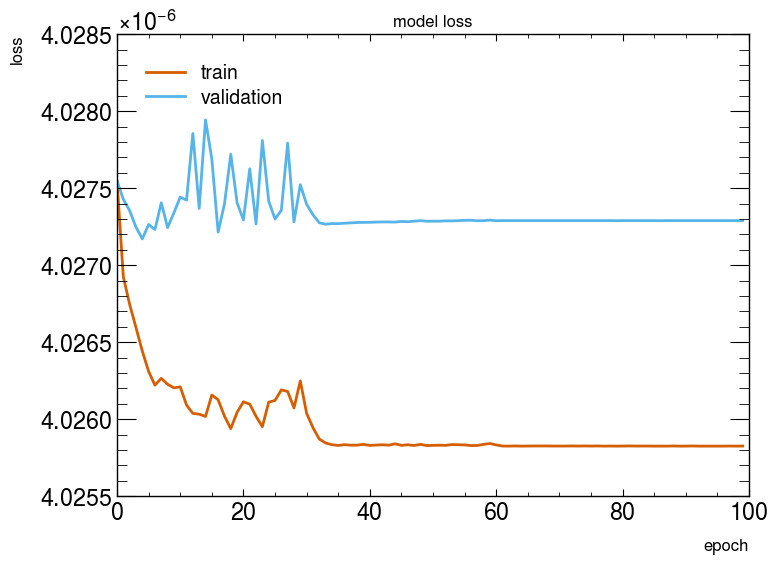

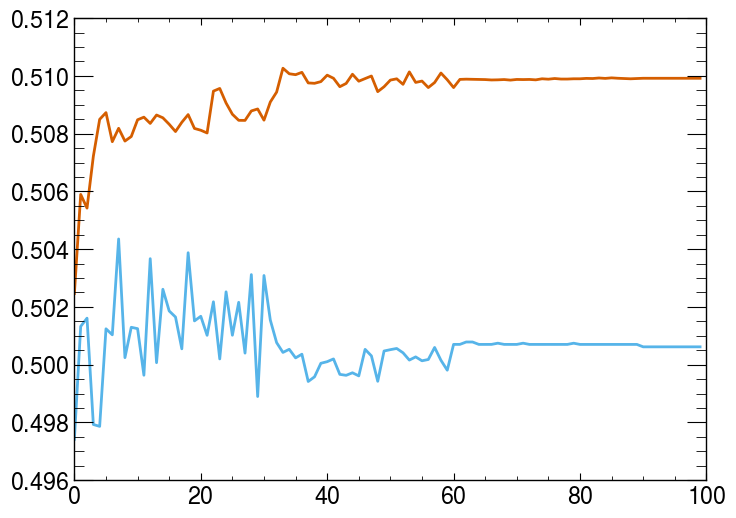

2025-11-11 12:18:43 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0003389992553773


2025-11-11 12:18:43 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0003389992553773



2025-11-11 12:18:43 | INFO | Training Logs | starting ensemble training
2025-11-11 12:18:43 | INFO | Training Logs | Sum of weights of class 0: 0.7000025510787964
2025-11-11 12:18:43 | INFO | Training Logs | Sum of weights of class 1: 0.7000024318695068
2025-11-11 12:18:43 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:18:43 | INFO | Training Logs | Using Call

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - binary_accuracy: 0.4995 - loss: 3.9960e-06 - val_binary_accuracy: 0.5060 - val_loss: 3.9955e-06 - learning_rate: 0.1000
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.5017 - loss: 3.9957e-06 - val_binary_accuracy: 0.5093 - val_loss: 3.9953e-06 - learning_rate: 0.1000
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.5042 - loss: 3.9955e-06 - val_binary_accuracy: 0.5076 - val_loss: 3.9950e-06 - learning_rate: 0.1000
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5061 - loss: 3.9953e-06 - val_binary_accuracy: 0.5102 - val_loss: 3.9948e-06 - learning_rate: 0.1000
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5057 - loss: 3.9952e-06 - val_binary_accuracy: 0.5091 - val_loss: 3.9947e-06 - learning_rate: 0.1000
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5052 - loss: 3.9952e-06 - val_binary_accuracy: 0.5096 - 

2025-11-11 12:19:55 | INFO | Training Logs | Finished Training
2025-11-11 12:19:55.165946: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:19:55.171245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:19:55.354001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:19:55.379656: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:19:55.384910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

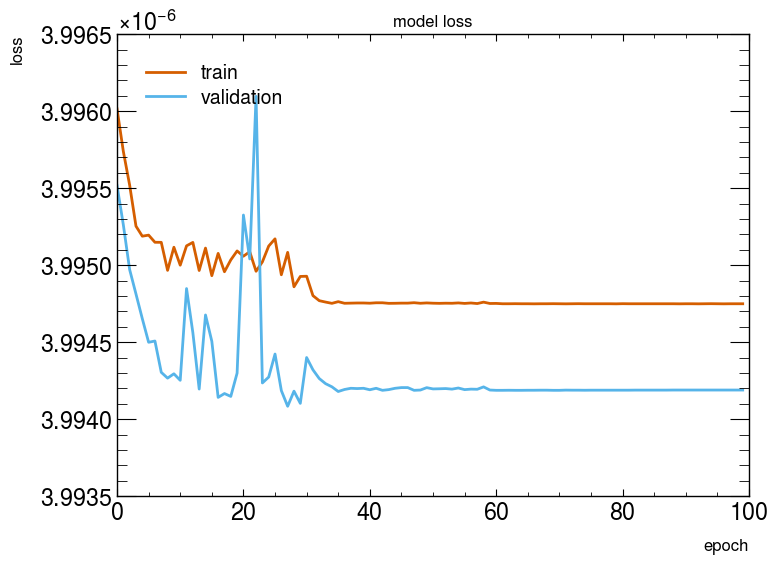

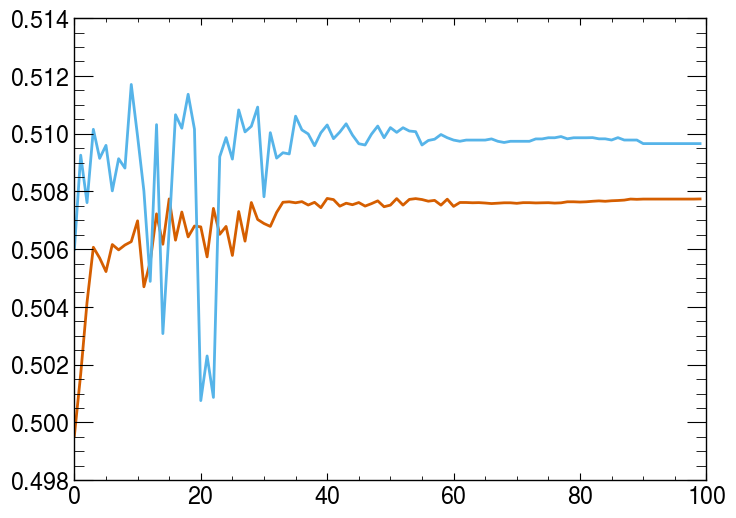

2025-11-11 12:19:58 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0001446794122375


2025-11-11 12:19:58 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0001446794122375



2025-11-11 12:19:58 | INFO | Training Logs | starting ensemble training
2025-11-11 12:19:58 | INFO | Training Logs | Sum of weights of class 0: 0.7000002861022949
2025-11-11 12:19:58 | INFO | Training Logs | Sum of weights of class 1: 0.7000013589859009
2025-11-11 12:19:58 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:19:58 | INFO | Training Logs | Using Call

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - binary_accuracy: 0.5054 - loss: 1.3992e-06 - val_binary_accuracy: 0.5050 - val_loss: 1.3992e-06 - learning_rate: 0.1000
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5066 - loss: 1.3990e-06 - val_binary_accuracy: 0.5037 - val_loss: 1.3992e-06 - learning_rate: 0.1000
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5074 - loss: 1.3990e-06 - val_binary_accuracy: 0.5033 - val_loss: 1.3992e-06 - learning_rate: 0.1000
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5083 - loss: 1.3990e-06 - val_binary_accuracy: 0.5036 - val_loss: 1.3992e-06 - learning_rate: 0.1000
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5082 - loss: 1.3990e-06 - val_binary_accuracy: 0.5034 - val_loss: 1.3992e-06 - learning_rate: 0.1000
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5080 - loss: 1.3990e-06 - val_binary_accuracy: 0.5042 - v

2025-11-11 12:22:49 | INFO | Training Logs | Finished Training
2025-11-11 12:22:49.614266: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:22:49.619734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:22:49.803339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:22:49.827141: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:22:49.832488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

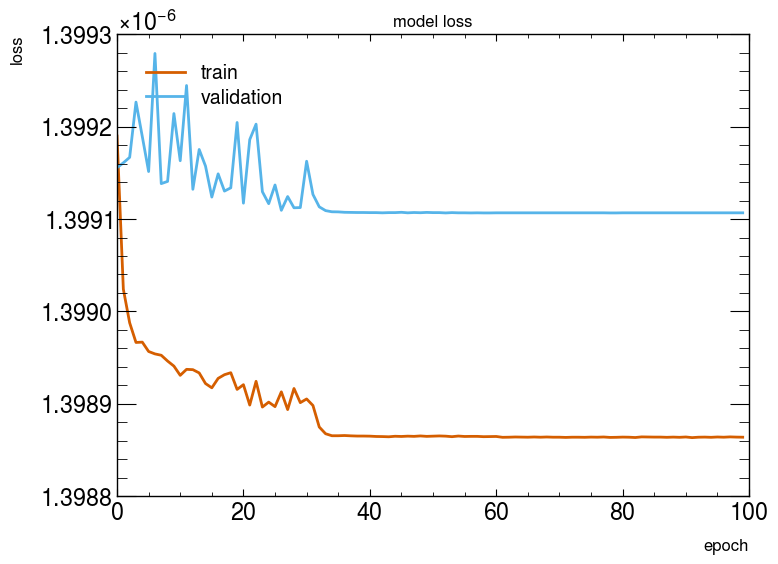

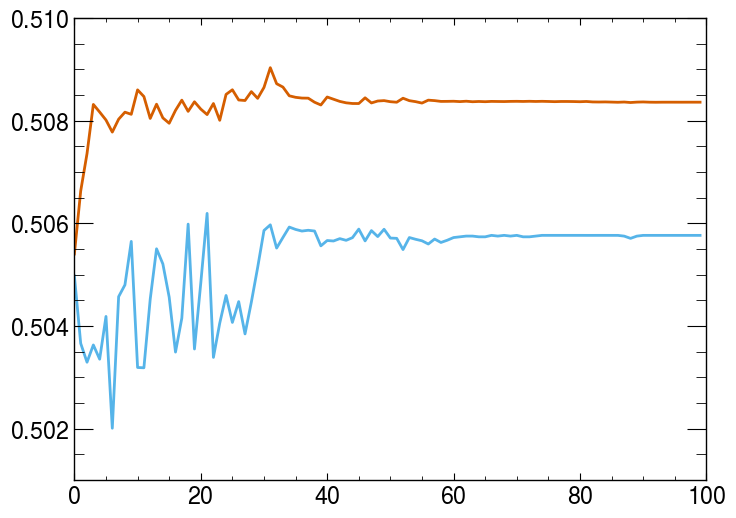

2025-11-11 12:22:54 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000520692197323


2025-11-11 12:22:54 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000520692197323



2025-11-11 12:22:54 | INFO | Training Logs | starting ensemble training
2025-11-11 12:22:54 | INFO | Training Logs | Sum of weights of class 0: 0.7000002861022949
2025-11-11 12:22:54 | INFO | Training Logs | Sum of weights of class 1: 0.7000007629394531
2025-11-11 12:22:54 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:22:54 | INFO | Training Logs | Using Call

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - binary_accuracy: 0.5057 - loss: 1.4321e-06 - val_binary_accuracy: 0.5053 - val_loss: 1.4320e-06 - learning_rate: 0.1000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5073 - loss: 1.4319e-06 - val_binary_accuracy: 0.5065 - val_loss: 1.4319e-06 - learning_rate: 0.1000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5078 - loss: 1.4319e-06 - val_binary_accuracy: 0.5084 - val_loss: 1.4319e-06 - learning_rate: 0.1000
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5081 - loss: 1.4319e-06 - val_binary_accuracy: 0.5072 - val_loss: 1.4319e-06 - learning_rate: 0.1000
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5081 - loss: 1.4319e-06 - val_binary_accuracy: 0.5065 - val_loss: 1.4319e-06 - learning_rate: 0.1000
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5081 - loss: 1.4319e-06 - val_binary_accuracy: 0.5065 - v

2025-11-11 12:25:41 | INFO | Training Logs | Finished Training
2025-11-11 12:25:41.926360: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:25:41.931702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:25:42.131025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:25:42.155072: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:25:42.160442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

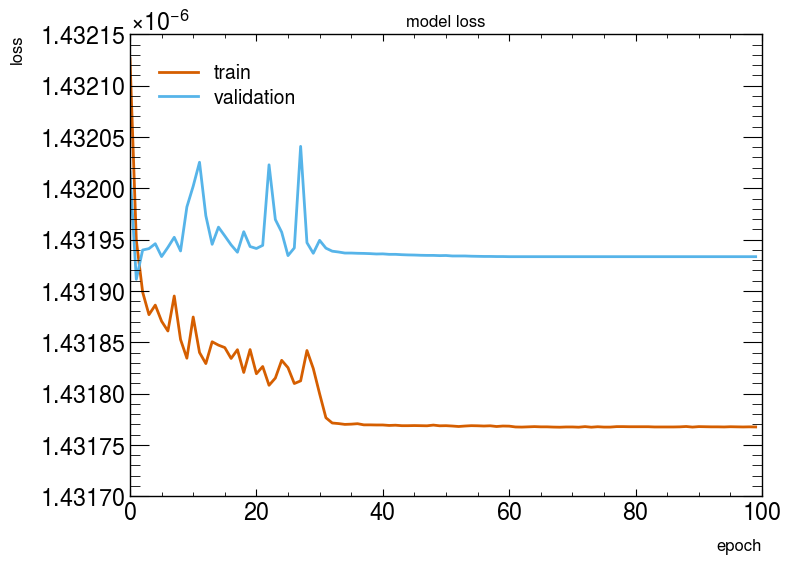

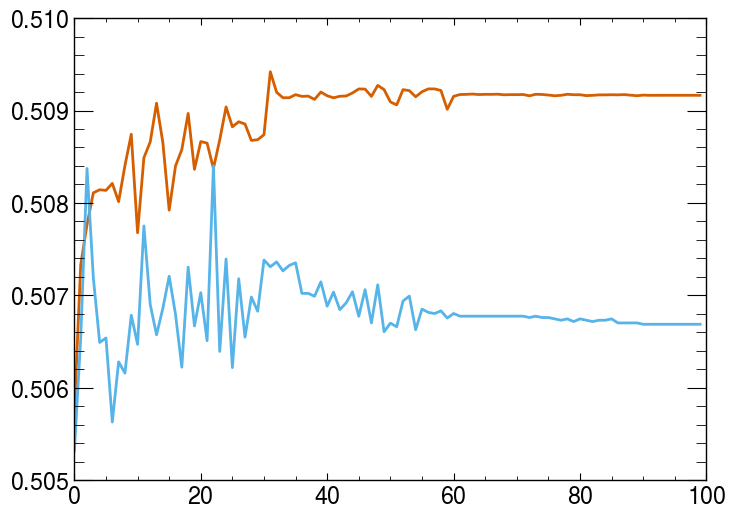

2025-11-11 12:25:46 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0000656899216969


2025-11-11 12:25:46 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0000656899216969



2025-11-11 12:25:46 | INFO | Training Logs | starting ensemble training
2025-11-11 12:25:47 | INFO | Training Logs | Sum of weights of class 0: 0.7000002861022949
2025-11-11 12:25:47 | INFO | Training Logs | Sum of weights of class 1: 0.7000005841255188
2025-11-11 12:25:47 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:25:47 | INFO | Training Logs | Using Call

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - binary_accuracy: 0.5076 - loss: 1.3760e-06 - val_binary_accuracy: 0.5051 - val_loss: 1.3760e-06 - learning_rate: 0.1000
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5111 - loss: 1.3757e-06 - val_binary_accuracy: 0.5082 - val_loss: 1.3758e-06 - learning_rate: 0.1000
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5138 - loss: 1.3755e-06 - val_binary_accuracy: 0.5108 - val_loss: 1.3756e-06 - learning_rate: 0.1000
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5150 - loss: 1.3753e-06 - val_binary_accuracy: 0.5129 - val_loss: 1.3754e-06 - learning_rate: 0.1000
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5153 - loss: 1.3752e-06 - val_binary_accuracy: 0.5160 - val_loss: 1.3753e-06 - learning_rate: 0.1000
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5172 - loss: 1.3750e-06 - val_binary_accuracy: 0.5157 - v

2025-11-11 12:28:41 | INFO | Training Logs | Finished Training
2025-11-11 12:28:41.178130: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:28:41.183482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:28:41.384876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:28:41.419678: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:28:41.425516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

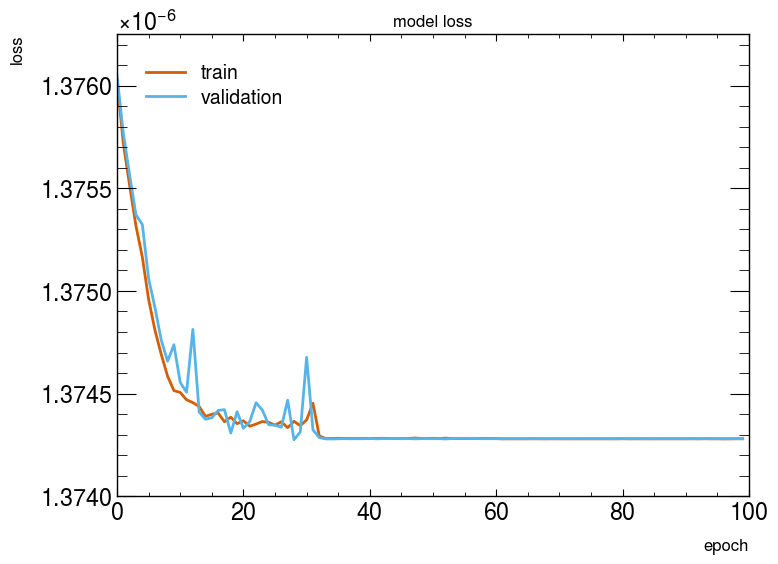

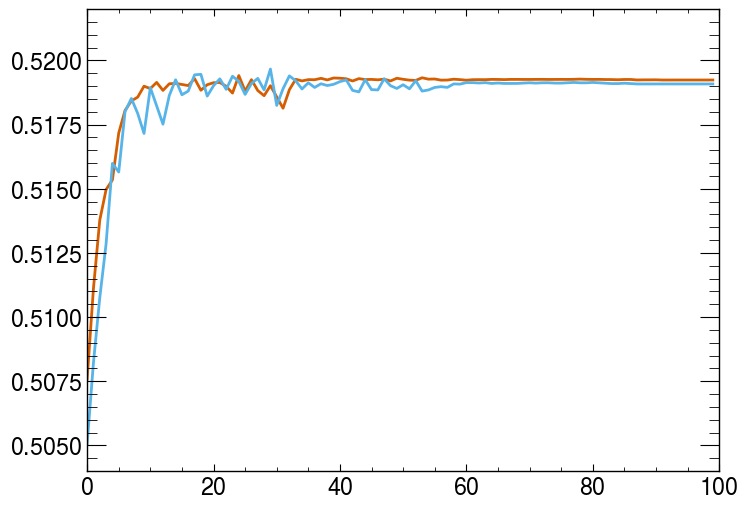

2025-11-11 12:28:46 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 0.9999925440949903


2025-11-11 12:28:46 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 0.9999925440949903



2025-11-11 12:28:46 | INFO | Training Logs | starting ensemble training
2025-11-11 12:28:46 | INFO | Training Logs | Sum of weights of class 0: 0.7000002861022949
2025-11-11 12:28:46 | INFO | Training Logs | Sum of weights of class 1: 0.7000003457069397
2025-11-11 12:28:46 | INFO | Training Logs | Using swish activation function
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-11 12:28:46 | INFO | Training Logs | Using Call

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - binary_accuracy: 0.5088 - loss: 1.4543e-06 - val_binary_accuracy: 0.5111 - val_loss: 1.4542e-06 - learning_rate: 0.1000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5121 - loss: 1.4539e-06 - val_binary_accuracy: 0.5132 - val_loss: 1.4539e-06 - learning_rate: 0.1000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5149 - loss: 1.4536e-06 - val_binary_accuracy: 0.5172 - val_loss: 1.4536e-06 - learning_rate: 0.1000
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5167 - loss: 1.4533e-06 - val_binary_accuracy: 0.5122 - val_loss: 1.4538e-06 - learning_rate: 0.1000
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5167 - loss: 1.4532e-06 - val_binary_accuracy: 0.5078 - val_loss: 1.4544e-06 - learning_rate: 0.1000
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5181 - loss: 1.4530e-06 - val_binary_accuracy: 0.5191 - v

2025-11-11 12:31:32 | INFO | Training Logs | Finished Training
2025-11-11 12:31:32.116463: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:31:32.121822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:31:32.305136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2025-11-11 12:31:32.329697: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-11-11 12:31:32.334992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVID

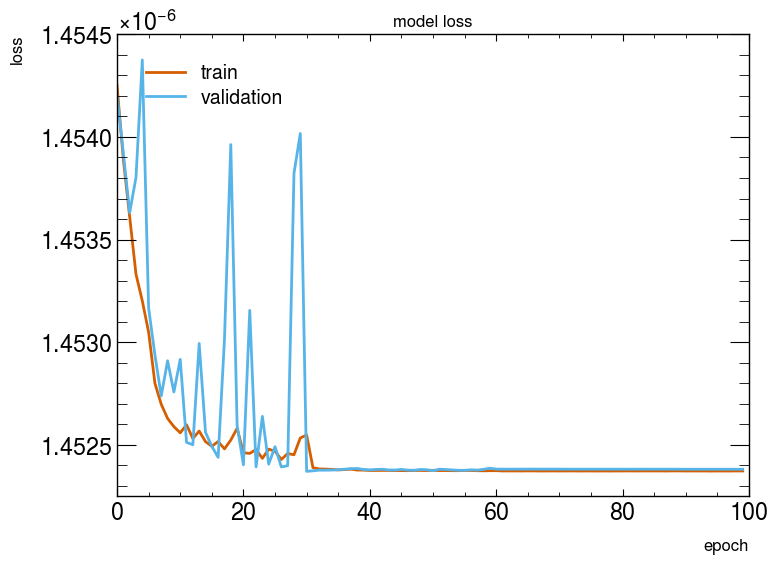

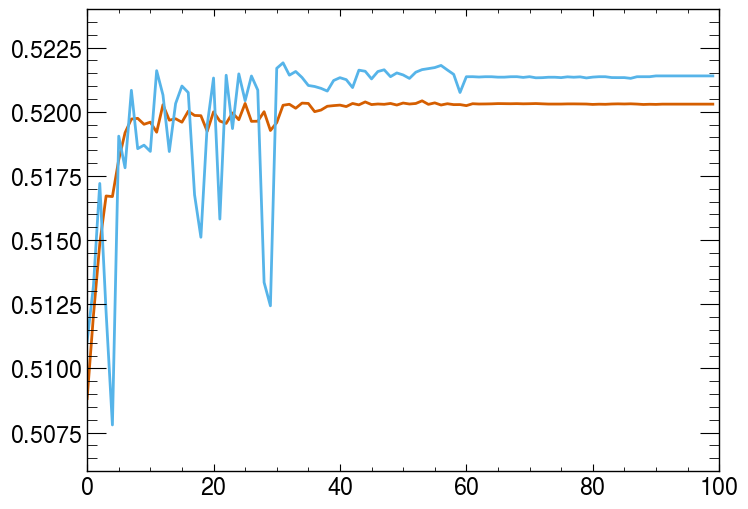

2025-11-11 12:31:36 | INFO | Training Logs | 


The sum of PDFs in ensemble member 0 is 1.0001408748653688


2025-11-11 12:31:36 | INFO | Training Logs | The sum of PDFs using the whole ensemble is 1.0001408748653688





<Figure size 800x600 with 0 Axes>

In [7]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = True
num_bins_cal = 50

USE_SAVED_MODELS = True
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 1

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process, process_dict in NN_training_syst_process.items():

    for syst, syst_dict in process_dict.items():
        
        for direction in syst_dict.keys():

            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 type_of_calibration  = "histogram",
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{c}(x)}{p_\text{c}(x)+p_\text{c}(x|\alpha_m^\pm)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x|\alpha_m^\pm)+p_\text{c}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_{c, \alpha_m^\pm}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_{c, \alpha_m^\pm}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


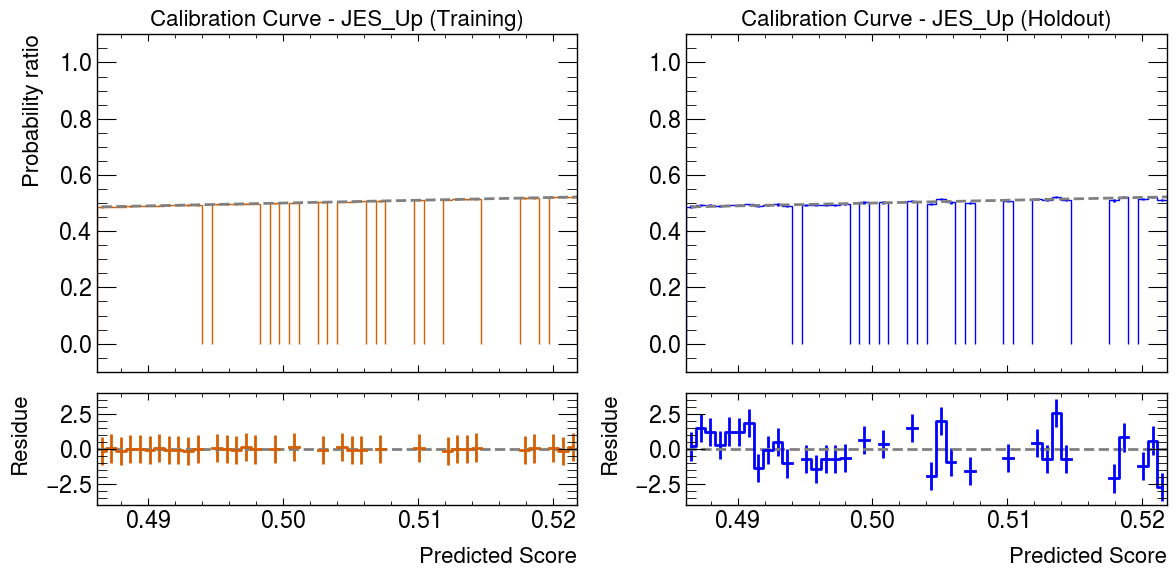

<Figure size 800x600 with 0 Axes>

In [8]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Up"].make_calib_plots(nbins=num_bins_cal, observable='score')


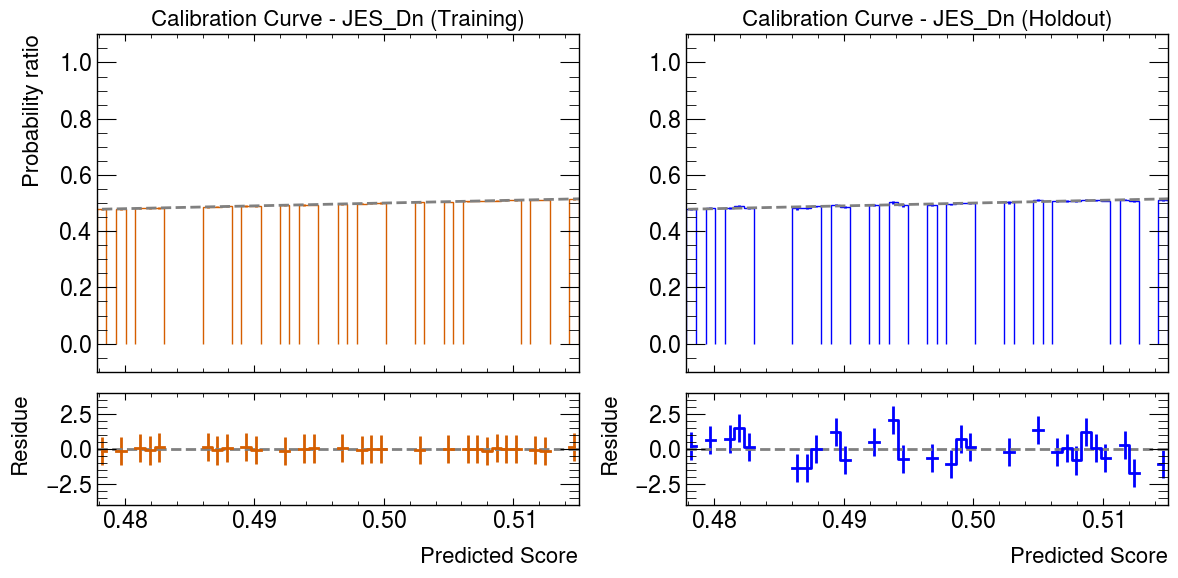

<Figure size 800x600 with 0 Axes>

In [9]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


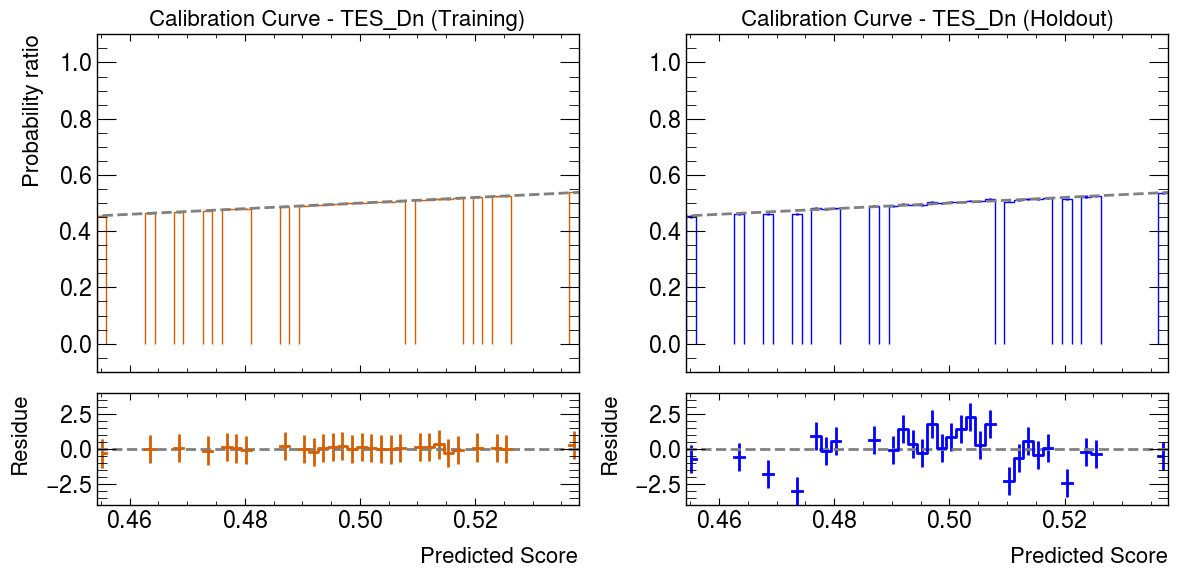

<Figure size 800x600 with 0 Axes>

In [10]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


## Density ratio reweighting closure tests
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x)} \times p_\text{c}(x) \sim p_\text{c}(x|\alpha_m^\pm)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

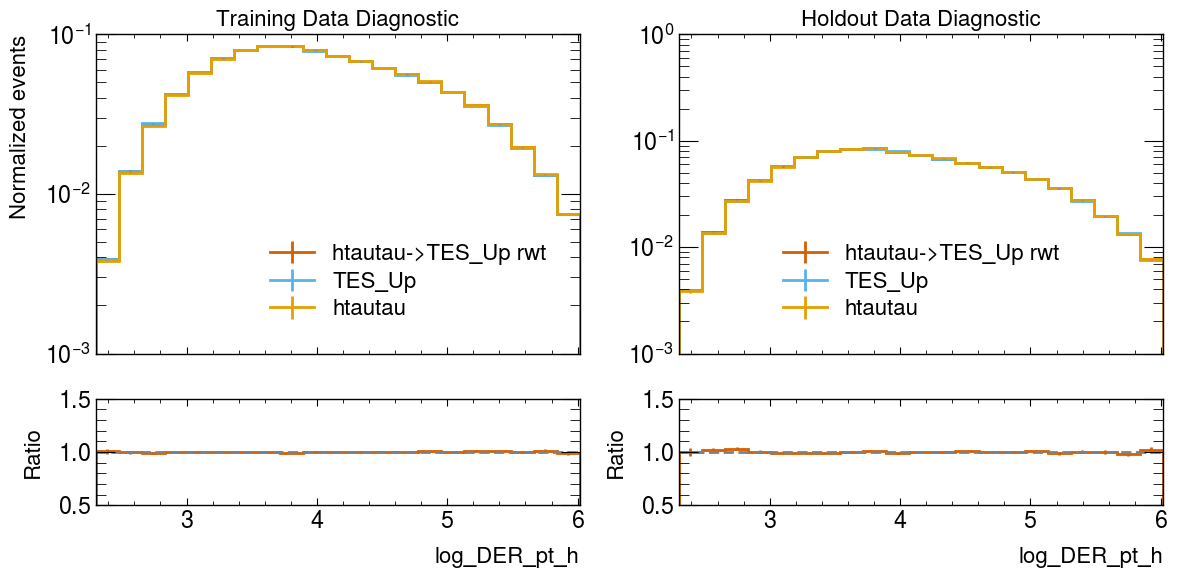

<Figure size 800x600 with 0 Axes>

In [11]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


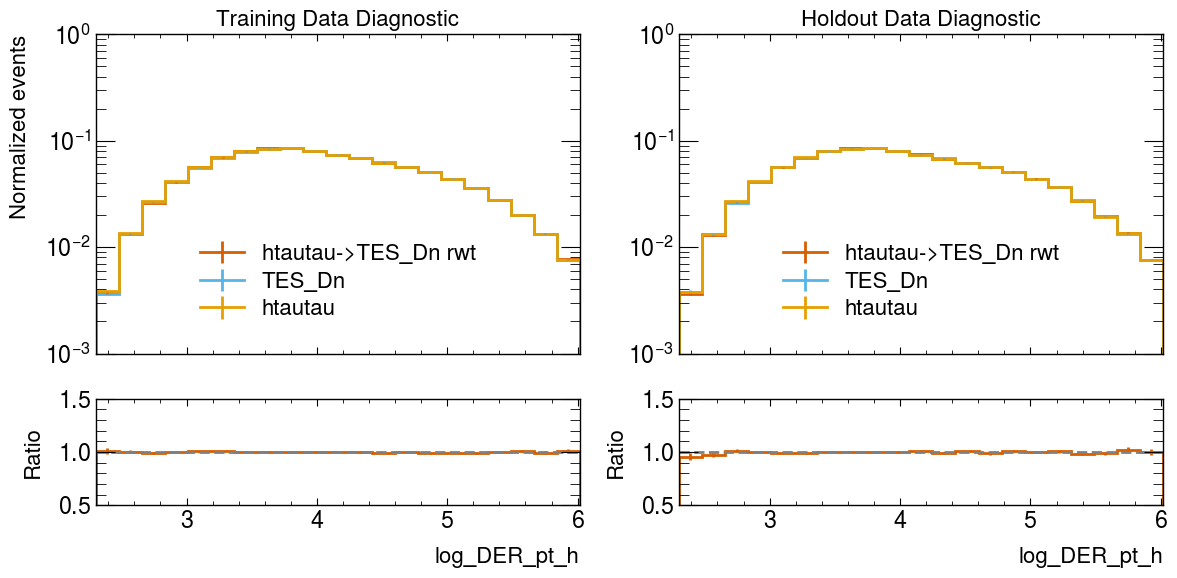

<Figure size 800x600 with 0 Axes>

In [12]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m = \alpha_m^\pm$ and process $p_\text{c}(x|\alpha_m^\pm)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [14]:
ensemble_aggregation_type = 'mean_ratio'

path_to_load = "saved_datasets/dataset_Asimov_SR.root"
dataset_Asimov_SR = nsbi_common_utils.datasets.load_dataframe_from_root(path_to_load     = path_to_load,
                                                                      tree_name        = "nominal",
                                                                      branches_to_load = branches_to_load)

path_to_saved_ratios = {}

for process in config.get_basis_samples():

    path_to_saved_ratios[process] = {}
    
    for dict_syst in config.config["Systematics"]:

        syst = dict_syst["Name"]
        
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"): continue

        path_to_saved_ratios[process][syst] = {}
        
        for direction in ["Up", "Dn"]:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset and save as numpy arrays
            path_to_saved_ratios[process][syst][direction] = NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_Asimov_SR, 
                                                                                        aggregation_type = ensemble_aggregation_type)


2025-11-11 12:33:26 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:28 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:30 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:32 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:34 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:36 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:37 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:39 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:41 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:43 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:45 | INFO | Training Logs | Evaluating density ratios
2025-11-11 12:33:47 | INFO | Training Logs | Evaluating density ratios


In [15]:
for variation_name, sample_dataset in dataset_SR_dict.items():
    if variation_name == 'Nominal': continue
    dataset_SR = Datasets.merge_dataframe_dict_for_training(dataset_SR_dict[variation_name], None, 
                                                            samples_to_merge = ["htautau", "ztautau", "ttbar"])

    path_to_save = f"{PATH_TO_SAVED_DATA}/dataset_{variation_name}_SR.root"
    nsbi_common_utils.datasets.save_dataframe_as_root(dataset_SR, 
                                                      path_to_save = path_to_save,
                                                      tree_name = "nominal")